In [1]:
from toolbox import dB2lin, dBm2watts, get_angle, watts2dBm, pack2dict
import numpy as np
import pandas as pd
from antenna import AntennaArray
import seaborn as sns 
import matplotlib.pyplot as plt
# Plotting style.
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
sns.despine(top=False, right=False, left=False, bottom=False)
sns.set_context("paper", font_scale=1.4)

<Figure size 432x288 with 0 Axes>

#### Example of beam sweeping with and without the RIS.

In [2]:
'''
Network topology (coordinates <x, y, z>).
'''
bs_loc  = np.array([0, 0, 0]) # Base station.
ris_loc = np.array([5, 5, 0]) # RIS.
ue_loc  = np.array([50, 0, 0]) # User equipment.
'''
Channel parameters.
'''
Ptx_dBm = 25
A_dB = -30 # 30 dB path loss attenuation.
alpha_bs2ris = 2.8 # Attenuation coefficient between base station and RIS.
alpha_ris2ue = 2.8 # ... between RIS and user equipment.
alpha_bs2ue  = 3.5 # ... between BS and user equipment.
'''
Antenna parameters.
''' 
element_gain_dBi = 1 # Antenna element gain.
fc = 30e9 # Carrier frequency in Hz.
wavelen = 3e8/fc # Wave length.
nx, ny, nz = 1, 8, 1 # Distribution of antenna elements. 
M = int(nx*ny*nz) # Number of antenna elements.
dx = dy = dz = wavelen * 0.5 # Distance between antenna elements.
nhbeams = 200 # Number of horizontal beams.
nvbeams = 1 # Number of vertical beams.
hangmin, hangmax = -90, 90 # Horizontal angles.
vangmin, vangmax = 0, 0 # Vertical angles.
antenna = AntennaArray(
    wavelen, nx, ny, nz, dx, dy, dz, hbeams=nhbeams, vbeams=nvbeams,
    hangmin=hangmin, hangmax=hangmax, vangmin=vangmin, vangmax=vangmax)
'''
RIS parameters.
'''
N = 300

In [3]:
def calc_prx(Cd, Cr, G, w_bs2ue, w_bs2ris, Gamma, Theta):
    '''
    This returns the received power in watts.
    '''
    # Don't ask me why this is the conjugate. It just works as in the 
    #   reference MATLAB code.
    psi = np.conj(np.matmul(Cd.T, w_bs2ue))
    # Don't ask me why this is the conjugate. It just works as in the 
    #   reference MATLAB code.
    A = np.conj(np.matmul(Cr.T, Gamma))
    B = np.matmul(A, Theta)
    C = np.matmul(B, G)
    D = np.matmul(C, w_bs2ris)
    prx = np.power(np.linalg.norm(D + psi), 2)
    return prx


def get_ris_coefficients(w_bs2ue, w_bs2ris, m, n, type_ris):
    if type_ris == "fixed":
        beta = np.ones(N)
        Gamma = np.diag(beta)
        theta = np.zeros(N)
        Theta = np.diag(np.exp(1j*theta))
    elif type_ris == "none":
        beta = np.zeros(N)
        Gamma = np.diag(beta)
        theta = np.zeros(N)
        Theta = np.diag(theta)
    else:
        assert True == False, \
            "Error, invalid RIS type! It should be either none or fixed."
    return Gamma, Theta

In [4]:
# Distances for the two links: (a) BS -> UE and (b) BS -> RIS -> UE.
d_bs2ris = np.linalg.norm(bs_loc-ris_loc)
d_ris2ue = np.linalg.norm(ris_loc-ue_loc)
d_bs2ue  = np.linalg.norm(bs_loc-ue_loc)
# Path loss coefficient.
A = dB2lin(A_dB)
# Transmit power.
p = np.sqrt(dBm2watts(Ptx_dBm)/M) * np.ones((M, 1)) # Transmit power per element.
# Channels.
# Direct channel, BS -> UE.
cd = np.sqrt(A*np.power(d_bs2ue, -alpha_bs2ue)/2.)*np.ones((M, 1))#(np.randn(M, 1) + 1j*np.randn(M, 1))
# Indirect channel, RIS -> UE.
cr = np.sqrt(A*np.power(d_ris2ue, -alpha_ris2ue)/2.)*np.ones((N, 1))#(np.randn(N, 1) + 1j*np.randn(N, 1))
# RIS channel, RIS -> UE.
g  = np.sqrt(A*np.power(d_bs2ris, -alpha_bs2ris)/2.)*np.ones((N, M))#(np.randn(N, M) + 1j*np.randn(N, M))
# Beam sweeping.

logs = {"prx_dBm": [], "beam_angle": [], "ris": []}

for type_ris in ["none", "fixed"]:
    for codebook_id in antenna.codebook_ids:
        phi2ue  = get_angle(ue_loc-bs_loc, ue_loc-bs_loc, unit="deg")
        phi2ris = get_angle(ris_loc-bs_loc, ue_loc-bs_loc, unit="deg")
        radiation, steering_angle = antenna.steering_vec(codebook_id, [phi2ue, phi2ris])
        w_bs2ue = np.multiply(p, radiation[0].reshape(M, 1))
        w_bs2ris = np.multiply(p, radiation[1].reshape(M, 1))
        # Received power.
        gamma, theta = get_ris_coefficients(w_bs2ue, w_bs2ris, M, N, type_ris)
        prx = calc_prx(cd, cr, g, w_bs2ue, w_bs2ris, gamma, theta)
        prx_dBm = watts2dBm(prx)
        
        _ = pack2dict(logs, [prx_dBm, steering_angle[1], type_ris])

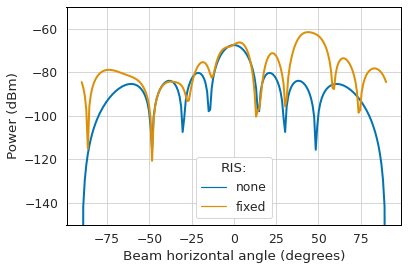

In [5]:
ax = sns.lineplot(
    data=pd.DataFrame(logs),
    x="beam_angle",
    y="prx_dBm",
    hue="ris",
    lw=2,
    # markers=True,
    # style="ris",
    # markersize=8,
    # markevery=10,
)
_ = plt.ylim([-150, -50])
_ = plt.ylabel("Power (dBm)")
_ = plt.xlabel("Beam horizontal angle (degrees)")
_ = plt.legend(title="RIS:", framealpha=1.0)